#Implementing Decision Trees for iris species

##Data Preparation

In [ ]:
import pandas as pd
from sklearn.datasets import load_iris

df = pd.read_csv('Iris.csv')

df.head()


# Load the Iris dataset
iris = load_iris()
df = pd.DataFrame(data=iris.data, columns=iris.feature_names)
df['species'] = iris.target
df['species'] = df['species'].map({0: 'setosa', 1: 'versicolor', 2: 'virginica'})

# Display the first few rows
print(df.head())



   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                5.1               3.5                1.4               0.2   
1                4.9               3.0                1.4               0.2   
2                4.7               3.2                1.3               0.2   
3                4.6               3.1                1.5               0.2   
4                5.0               3.6                1.4               0.2   

  species  
0  setosa  
1  setosa  
2  setosa  
3  setosa  
4  setosa  


##Functions for finding gini impurity, entropy and information gain

In [ ]:
import numpy as np

def gini_impurity(y):
    classes, counts = np.unique(y, return_counts=True)
    return 1 - sum((counts / counts.sum()) ** 2)

In [ ]:

def entropy(y):
    classes, counts = np.unique(y, return_counts=True)
    probabilities = counts / counts.sum()
    return -sum(p * np.log2(p) for p in probabilities if p > 0)

In [ ]:
def information_gain(y, X_col, split_threshold):
    parent_entropy = entropy(y)

    left_indices = X_col <= split_threshold
    right_indices = X_col > split_threshold

    if len(y[left_indices]) == 0 or len(y[right_indices]) == 0:
        return 0

    n = len(y)
    n_left, n_right = len(y[left_indices]), len(y[right_indices])

    child_entropy = (n_left / n) * entropy(y[left_indices]) + (n_right / n) * entropy(y[right_indices])
    return parent_entropy - child_entropy

In [ ]:
def best_split(X, y):
    best_gain = -1
    best_threshold = None
    best_column = None

    for col in range(X.shape[1]):
        thresholds = np.unique(X[:, col])
        for threshold in thresholds:
            gain = information_gain(y, X[:, col], threshold)
            if gain > best_gain:
                best_gain = gain
                best_threshold = threshold
                best_column = col

    return best_gain, best_column, best_threshold


##Implement Decision Tree Algorithms

In [ ]:
class DecisionTree:
    def __init__(self, max_depth=None, criterion='entropy'):
        self.max_depth = max_depth
        self.criterion = criterion
        self.tree = None

    def fit(self, X, y):
        self.tree = self._grow_tree(X, y)

    def _grow_tree(self, X, y, depth=0):
        n_samples, n_features = X.shape
        unique_classes = np.unique(y)

        # Check for stopping criteria
        if (len(unique_classes) == 1 or
            (self.max_depth is not None and depth >= self.max_depth)):
            return unique_classes[0]  # Return the class label

        gain, column, threshold = best_split(X, y)
        if gain == 0:
            return unique_classes[0]  # Return the class label

        left_indices = X[:, column] <= threshold
        right_indices = X[:, column] > threshold

        left_tree = self._grow_tree(X[left_indices], y[left_indices], depth + 1)
        right_tree = self._grow_tree(X[right_indices], y[right_indices], depth + 1)

        return (column, threshold, left_tree, right_tree)

    def predict(self, X):
        return np.array([self._predict(sample, self.tree) for sample in X])

    def _predict(self, sample, tree):
        if not isinstance(tree, tuple):
            return tree  # Leaf node, return the class label

        column, threshold, left_tree, right_tree = tree
        if sample[column] <= threshold:
            return self._predict(sample, left_tree)
        else:
            return self._predict(sample, right_tree)


##Building and Visualizing Trees

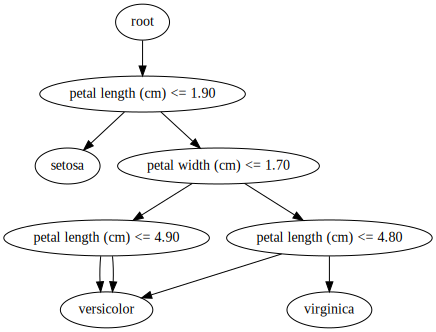

In [ ]:
from graphviz import Digraph

def visualize_tree(tree, feature_names):
    dot = Digraph()

    def add_nodes_edges(tree, parent_name, graph):
        if not isinstance(tree, tuple):
            graph.node(str(tree), str(tree))
            graph.edge(parent_name, str(tree))
            return

        column, threshold, left_tree, right_tree = tree
        node_name = f"{feature_names[column]} <= {threshold:.2f}"
        graph.node(node_name)
        graph.edge(parent_name, node_name)

        add_nodes_edges(left_tree, node_name, graph)
        add_nodes_edges(right_tree, node_name, graph)

    add_nodes_edges(tree, "root", dot)
    return dot

# Example of usage
X = df.iloc[:, :-1].values
y = df['species'].values
tree_model = DecisionTree(max_depth=3)
tree_model.fit(X, y)
dot = visualize_tree(tree_model.tree, iris.feature_names)
dot


#Evaluation

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


tree_model.fit(X_train, y_train)
predictions = tree_model.predict(X_test)

# Evaluate
accuracy = accuracy_score(y_test, predictions)
report = classification_report(y_test, predictions)

print(f"Accuracy: {accuracy}")
print(report)


Accuracy: 0.8444444444444444
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        19
  versicolor       0.69      0.85      0.76        13
   virginica       0.80      0.62      0.70        13

    accuracy                           0.84        45
   macro avg       0.83      0.82      0.82        45
weighted avg       0.85      0.84      0.84        45

